In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('/content/Boston-filtered.csv')

In [70]:
# Features and target
X = df.drop('MEDV', axis=1).values
y = df['MEDV'].values

# Split data into 2/3 training and 1/3 testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

In [124]:
# Define custom Kernel Ridge Regression class
class KernelRidgeRegression:
    def __init__(self, gamma=1.0, sigma=1.0):
        self.gamma = gamma  # Regularisation strength
        self.sigma = sigma  # Kernel coefficient

    def _rbf_kernel(self, X, Y=None):
        if Y is None:
            Y = X
        dist_matrix = np.sum(X**2, axis=1)[:, None] + np.sum(Y**2, axis=1) - 2 * X @ Y.T
        return np.exp(-dist_matrix / (2 * self.sigma**2))

    def fit(self, X, y):
        K = self._rbf_kernel(X)
        n = K.shape[0]
        self.alpha_ = np.linalg.inv(K + self.gamma * n * np.eye(n)) @ y
        self.X_fit_ = X  # Store the training data for prediction

    def predict(self, X):
        # Ensure we use self.X_fit_ instead of self.X
        K = self._rbf_kernel(X, self.X_fit_)
        return K @ self.alpha_

# Custom MSE function
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [138]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

gamma_values = [2**-i for i in range(40, 25, -1)]  # Regularisation strength values
sigma_values = [2**i for i in np.arange(7, 13.5, 0.5)]  # Kernel coefficient values

# Cross-validation to find the best gamma and sigma
best_gamma = None
best_sigma = None
best_mse = float('inf')

cv_errors_array = np.zeros((len(gamma_values), len(sigma_values)))

for i, gamma in enumerate(gamma_values):
    for j, sigma in enumerate(sigma_values):
        krr = KernelRidgeRegression(gamma=gamma, sigma=sigma)

        # Perform 5-fold cross-validation on the training data
        fold_errors = []
        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Train and evaluate
            krr.fit(X_train_fold, y_train_fold)
            y_val_pred = krr.predict(X_val_fold)
            fold_errors.append(mean_squared_error(y_val_fold, y_val_pred))

        # Store average MSE across folds in the array
        avg_mse = np.mean(fold_errors)
        cv_errors_array[i, j] = avg_mse  # Store in cv_errors_array for heatmap

        if avg_mse < best_mse:
            best_mse = avg_mse
            best_gamma = gamma
            best_sigma = sigma

print(f"Best gamma (reg strength): {best_gamma}")
print(f"Best sigma (kernel coefficient): {best_sigma}")
print(f"Best Cross-Validation MSE: {best_mse}")

Best gamma (reg strength): 2.3283064365386963e-10
Best sigma (kernel coefficient): 1024.0
Best Cross-Validation MSE: 16.967402685603616


1024.0


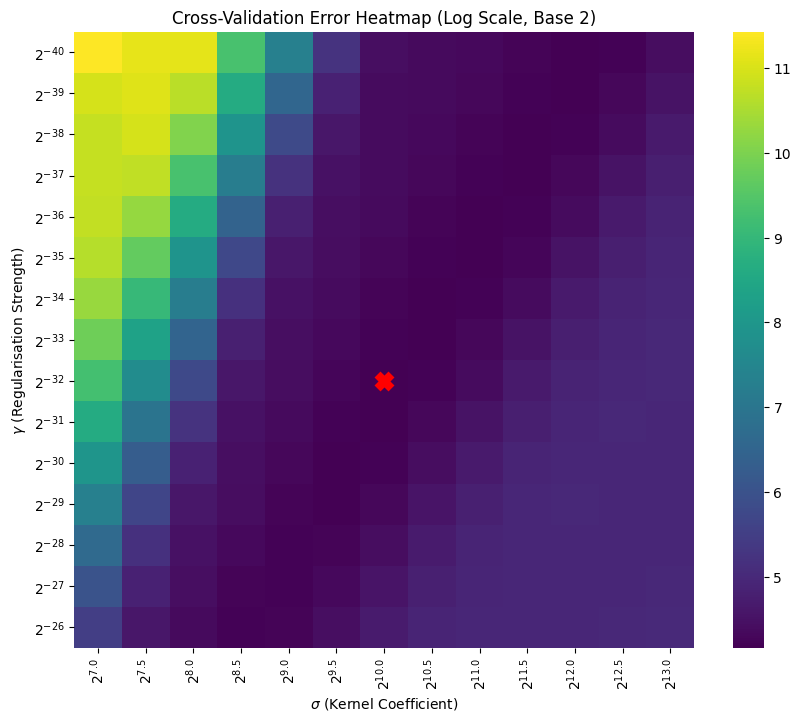

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Convert cv_errors_array to log scale for visual clarity
cv_errors_log_array = np.log2(cv_errors_array + 1)  # Adding 1 to avoid log(0) issues

# Convert gamma and sigma values to arrays for easy indexing
gamma_values_arr = np.array(gamma_values)
sigma_values_arr = np.array(sigma_values)
optimal_gamma_index = np.where(gamma_values_arr == best_gamma)[0][0]
optimal_sigma_index = np.where(sigma_values_arr == best_sigma)[0][0]

plt.figure(figsize=(10, 8))
sns.heatmap(cv_errors_log_array, annot=False, cmap="viridis", fmt=".2f",
            xticklabels=False, yticklabels=False)

# Set tick positions and labels manually, simulating powers of 2
plt.xticks(ticks=np.arange(len(sigma_values)) + 0.5, labels=[f"$2^{{{i}}}$" for i in np.arange(7, 13.5, 0.5)], rotation=90)
plt.yticks(ticks=np.arange(len(gamma_values)) + 0.5, labels=[f"$2^{{-{i}}}$" for i in range(40, 25, -1)], rotation=0)

# Plot optimal point, adjusting for cell center
plt.plot(optimal_sigma_index + 0.5, optimal_gamma_index + 0.5, 'rX', markersize=12, markeredgewidth=2)

plt.xlabel("$\sigma$ (Kernel Coefficient)")
plt.ylabel("$\gamma$ (Regularisation Strength)")
plt.title("Cross-Validation Error Heatmap (Log Scale, Base 2)")
plt.show()


In [145]:
# Retrain model with the best parameters on the full training set


krr_best = KernelRidgeRegression(gamma=best_gamma, sigma=best_sigma)
krr_best.fit(X_train, y_train)

# Calculate training and testing errors
train_predictions = krr_best.predict(X_train)
test_predictions = krr_best.predict(X_test)

train_error = mean_squared_error(y_train, train_predictions)
test_error = mean_squared_error(y_test, test_predictions)

print(f"Training Error (MSE): {train_error}")
print(f"Test Error (MSE): {test_error}")

Training Error (MSE): 8.04914023473071
Test Error (MSE): 12.588864179773449
2.3283064365386963e-10


Here we compare different regression methods by averaging each over 20 test/training splits

In [152]:
import numpy as np
from sklearn.model_selection import train_test_split

target_col = 'MEDV'

def add_bias_term(df):
    df = df.copy()
    df['bias'] = 1
    return df

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def linear_regression(X, y):
    X_transpose = X.T
    return np.linalg.inv(X_transpose @ X) @ X_transpose @ y

def generate_splits(data, test_size=1/3, n_splits=20, random_seed=42):
    train_splits, test_splits = [], []
    for i in range(n_splits):
        train, test = train_test_split(data, test_size=test_size, random_state=random_seed + i)
        train_splits.append(train)
        test_splits.append(test)
    return train_splits, test_splits

# Naive Regression
def naive_regression(train_splits, test_splits):
    train_mse_list, test_mse_list = [], []
    for train, test in zip(train_splits, test_splits):
        y_train, y_test = train[target_col], test[target_col]
        constant_value = y_train.mean()
        train_mse_list.append(mean_squared_error(y_train, [constant_value] * len(y_train)))
        test_mse_list.append(mean_squared_error(y_test, [constant_value] * len(y_test)))
    return np.mean(train_mse_list), np.std(train_mse_list), np.mean(test_mse_list), np.std(test_mse_list)

# Single Attribute Regression
def single_attribute_regression(df, train_splits, test_splits):
    train_mse_results = {col: [] for col in df.columns if col != target_col}
    test_mse_results = {col: [] for col in df.columns if col != target_col}
    for attribute in train_mse_results.keys():
        for train, test in zip(train_splits, test_splits):
            X_train, y_train = add_bias_term(train[[attribute]]), train[target_col]
            X_test, y_test = add_bias_term(test[[attribute]]), test[target_col]
            weights = linear_regression(X_train.values, y_train.values)
            train_mse_results[attribute].append(mean_squared_error(y_train, X_train.values @ weights))
            test_mse_results[attribute].append(mean_squared_error(y_test, X_test.values @ weights))
    return {
        attr: (np.mean(mse_list), np.std(mse_list))
        for attr, mse_list in train_mse_results.items()
    }, {
        attr: (np.mean(mse_list), np.std(mse_list))
        for attr, mse_list in test_mse_results.items()
    }

# Linear Regression with All Attributes
def full_attribute_regression(df, train_splits, test_splits):
    train_mse_list, test_mse_list = [], []
    for train, test in zip(train_splits, test_splits):
        X_train, y_train = add_bias_term(train.drop(columns=[target_col])), train[target_col]
        X_test, y_test = add_bias_term(test.drop(columns=[target_col])), test[target_col]
        weights = linear_regression(X_train.values, y_train.values)
        train_mse_list.append(mean_squared_error(y_train, X_train.values @ weights))
        test_mse_list.append(mean_squared_error(y_test, X_test.values @ weights))
    return np.mean(train_mse_list), np.std(train_mse_list), np.mean(test_mse_list), np.std(test_mse_list)

# Kernel Ridge Regression Evaluation
def kernel_ridge_regression_eval(df, train_splits, test_splits, gamma=best_gamma, sigma=best_sigma):
    train_mse_list, test_mse_list = [], []
    for train, test in zip(train_splits, test_splits):
        X_train, y_train = train.drop(columns=[target_col]).values, train[target_col].values
        X_test, y_test = test.drop(columns=[target_col]).values, test[target_col].values

        # Instantiate and fit Kernel Ridge Regression model
        krr = KernelRidgeRegression(gamma=gamma, sigma=sigma)
        krr.fit(X_train, y_train)

        # Predict and calculate MSE for training and test data
        train_mse_list.append(mean_squared_error(y_train, krr.predict(X_train)))
        test_mse_list.append(mean_squared_error(y_test, krr.predict(X_test)))

    return np.mean(train_mse_list), np.std(train_mse_list), np.mean(test_mse_list), np.std(test_mse_list)


# Run the regressions
train_splits, test_splits = generate_splits(df)

# Naive Regression Results
average_train_mse, std_train_mse, average_test_mse, std_test_mse = naive_regression(train_splits, test_splits)

# Single Attribute Regression Results
train_mse_single, test_mse_single = single_attribute_regression(df, train_splits, test_splits)

# Full Attribute Regression Results
avg_train_mse_full, std_train_mse_full, avg_test_mse_full, std_test_mse_full = full_attribute_regression(df, train_splits, test_splits)

# Kernel Ridge Regression Results with best parameters
train_mse_mean, train_mse_std, test_mse_mean, test_mse_std = kernel_ridge_regression_eval(df, train_splits, test_splits, best_gamma, best_sigma)


In [153]:
import pandas as pd

# Assuming the following variables contain your computed values
# Naive Regression Results
naive_train_mse, naive_train_std, naive_test_mse, naive_test_std = average_train_mse, std_train_mse, average_test_mse, std_test_mse

# Single Attribute Regression Results (Dictionary format for each attribute)
single_train_mse_results = {attr: (avg_mse, std_dev) for attr, (avg_mse, std_dev) in train_mse_single.items()}
single_test_mse_results = {attr: (avg_mse, std_dev) for attr, (avg_mse, std_dev) in test_mse_single.items()}

# Full Attribute Regression Results
full_train_mse, full_train_std, full_test_mse, full_test_std = avg_train_mse_full, std_train_mse_full, avg_test_mse_full, std_test_mse_full

# Kernel Ridge Regression Results
krr_train_mse, krr_train_std, krr_test_mse, krr_test_std = train_mse_mean, train_mse_std, test_mse_mean, test_mse_std

# Create table in DataFrame format
data = {
    "Method": ["Naive Regression"] +
              [f"Linear Regression (attribute {i+1})" for i in range(12)] +
              ["Linear Regression (all attributes)", "Kernel Ridge Regression"],
    "MSE Train": [
        f"{naive_train_mse:.2f} ± {naive_train_std:.2f}"
    ] + [
        f"{single_train_mse_results[attr][0]:.2f} ± {single_train_mse_results[attr][1]:.2f}" for attr in single_train_mse_results.keys()
    ] + [
        f"{full_train_mse:.2f} ± {full_train_std:.2f}",
        f"{krr_train_mse:.2f} ± {krr_train_std:.2f}"
    ],
    "MSE Test": [
        f"{naive_test_mse:.2f} ± {naive_test_std:.2f}"
    ] + [
        f"{single_test_mse_results[attr][0]:.2f} ± {single_test_mse_results[attr][1]:.2f}" for attr in single_test_mse_results.keys()
    ] + [
        f"{full_test_mse:.2f} ± {full_test_std:.2f}",
        f"{krr_test_mse:.2f} ± {krr_test_std:.2f}"
    ]
}

# Create the DataFrame
df_results = pd.DataFrame(data)

# Display the DataFrame in a tabular format
df_results


,Method,MSE Train,MSE Test
0,Naive Regression,82.83 ± 4.68,87.82 ± 9.37
1,Linear Regression (attribute 1),70.15 ± 4.70,76.35 ± 10.83
2,Linear Regression (attribute 2),72.87 ± 4.95,75.05 ± 9.92
3,Linear Regression (attribute 3),63.32 ± 4.70,67.63 ± 9.46
4,Linear Regression (attribute 4),80.51 ± 4.19,85.25 ± 8.88
5,Linear Regression (attribute 5),67.65 ± 4.28,72.12 ± 8.67
6,Linear Regression (attribute 6),42.87 ± 2.90,45.44 ± 5.85
7,Linear Regression (attribute 7),71.18 ± 4.63,75.25 ± 9.34
8,Linear Regression (attribute 8),77.66 ± 4.92,82.43 ± 9.86
9,Linear Regression (attribute 9),70.55 ± 4.29,75.60 ± 8.67
